In [1]:
%cd H:\GitHub\pytracer\

H:\GitHub\pytracer


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scripts.assemblies as assembly
import pytracer.geometry as geo
import pytracer.transmission as transmission

In [3]:
def distance(x1, y1, x2, y2):
    tmp = 0

    tmp = (x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2)
    return np.sqrt(tmp)


def sign_line(x, y, x1, y1, x2, y2):
    return (x - x1) * (y1 - y2) + (y - y1) * (x2 - x1)


def point_segment_distance(px, py, x0, x1, y0, y1):
    length_sq = (x1 - x0) * (x1 - x0) + (y1 - y0) * (y1 - y0)
    if length_sq <= 0:
        distance = np.sqrt((px - x0) * (px - x0) + (py - y0) * (py - y0))
        return distance

    t = (px - x0) * (x1 - x0) + (py - y0) * (y1 - y0)
    t /= length_sq
    if t > 1:
        t = 1
    elif t < 0:
        t = 0

    projection_x = x0 + t * (x1 - x0)
    projection_y = y0 + t * (y1 - y0)
    distance = (px - projection_x) * (px - projection_x) + (py - projection_y) * (py - projection_y)
    distance = np.sqrt(distance)
    return distance


def p_at_point(point_x, point_y, segments, pfuncrefs, pfuncs):
    """ Based on looking at segment with smallest distance """
    min_distance = 1e99
    point_absorbance = 0

    for i in range(segments.shape[0]):
        distance = point_segment_distance(point_x, point_y, segments[i, 0, 0], segments[i, 1, 0],
                                          segments[i, 0, 1], segments[i, 1, 1])
        if distance < min_distance:
            min_distance = distance
            is_outer = sign_line(point_x, point_y, segments[i, 0, 0], segments[i, 0, 1],
                                 segments[i, 1, 0], segments[i, 1, 1])
            in_p = 0
            out_p = 0
            if pfuncrefs[i, 0] > 0:
                in_p = pfuncs[pfuncrefs[i, 0]](point_x, point_y)
            if pfuncrefs[i, 1] > 0:
                out_p = pfuncs[pfuncrefs[i, 1]](point_x, point_y)

            if is_outer == 0:
                point_absorbance = (in_p + out_p) / 2
            elif is_outer > 0:
                point_absorbance = out_p
            else:
                point_absorbance = in_p
    return point_absorbance


def p_image(xs, ys, flat_geom):
    image = np.zeros((np.size(xs, 0), np.size(ys, 0)), dtype=np.double)
    extent = [xs[0], xs[-1], ys[0], ys[-1]]

    for i in range(xs.shape[0]):
        for j in range(ys.shape[0]):
            image[i, j] = p_at_point(xs[i], ys[j], flat_geom.segments, flat_geom.pfuncrefs, flat_geom.pfuncs)

    return image, extent


def foo(xs, ys):
    xs -= assembly._circle_origin[0]
    ys -= assembly._circle_origin[1]
    ring_center_radius = (
                         assembly._circle_outer_radius - assembly._circle_inner_radius) / 2 + assembly._circle_inner_radius
    xv, yv = np.meshgrid(xs, ys)
    radius = np.sqrt(xv ** 2 + yv[::-1] ** 2)
    zs = -0.5 * (radius - ring_center_radius) ** 2 + 0.18

    slope = - 0.05 / (1.1 * assembly._circle_outer_radius)
    zs += slope * xv - 0.05

    zs[zs < 0] = 0
    return zs

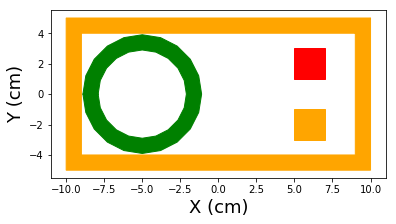

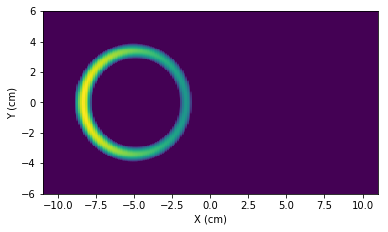

In [4]:
assembly_solids = assembly.shielded_assembly()
assembly_flat = geo.flatten(assembly_solids)

plt.figure()
geo.draw(assembly_solids)
plt.xlabel('X (cm)', size=18)
plt.ylabel('Y (cm)', size=18)
ax = plt.gca()
ax.set_aspect('equal')

xs = np.linspace(-11, 11, 200)
ys = np.linspace(-6, 6, 200)

image, extent = p_image(xs, ys, assembly_flat)

zs = foo(xs, ys)
# zs = image.T

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(zs, interpolation='none', extent=extent)
# plt.colorbar(im)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_aspect('equal')
plt.show()